**Work in progress**

I'm interested in prescribing of Lidocaine patches since 2015. Details of lidocaine plasters prescribing can be seen on [OpenPrescribing here](https://openprescribing.net/measure/lplidocaine/national/england/). Previous DataLab work on evaluation on the impact of NHS England guidance can be viewed [here in JRSM](https://journals.sagepub.com/doi/10.1177/0141076818808429)

The following example notebooks for reference for re-using code snippets
- https://github.com/ebmdatalab/lidocaine-change-detection-notebook/blob/master/notebooks/ccg-lidocaine-change.ipynb
- https://github.com/ebmdatalab/jupyter-notebooks/blob/master/Dementia%20Prescribing/Dementia%20Prescribing.ipynb
- https://github.com/ebmdatalab/jupyter-notebooks/blob/master/new_measures/Gabapentinoids/New%20Measure%20-%20Gabapentin%20and%20Pregabalin%20DDD.ipynb
- https://github.com/ebmdatalab/cd-legislation-notebook/blob/master/notebooks/legislative.change.ipynb
    

## Data Extraction

- Lidocaine here
- See below for list size (add navigation later)

In [1]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
## here we will extract all prescribing of Lidocaine patches by ccg (prev named pct)
sql= '''
SELECT
DATE(month) AS month,
  pct,
  SUM(quantity) AS quantity_of_plasters,
  SUM(items) AS rx_items,
  SUM(actual_cost) AS actual_cost,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
  INNER JOIN hscic.ccgs AS ccg ON rx.pct = ccg.code 
WHERE
  bnf_code LIKE "1502010J0%EL" # brand and Lidocaine patches
  AND month >= "2015-01-01"
  AND ccg.org_type = 'CCG' #restrict to only ccg orgs i.e. exclude OOH etc
GROUP BY
   month,
   pct
 '''

df_lidocaine = bq.cached_read(sql, csv_path=os.path.join('..', 'data','lidocaine.csv'), use_cache=True)
df_lidocaine['month'] = df_lidocaine['month'].astype('datetime64[ns]')
df_lidocaine.head(10)

,month,pct,quantity_of_plasters,rx_items,actual_cost,net_cost
0,2020-05-01,D4U1Y,3820.00,111,8561.62,9208.09
1,2019-07-01,B2M3M,3195.00,98,6735.68,7243.63
2,2019-07-01,06H,1655.00,53,3713.97,3994.06
3,2018-07-01,B2M3M,3935.00,129,8275.57,8906.42
4,2018-07-01,02P,2230.00,68,4999.85,5381.73
5,2019-05-01,01H,2165.00,69,4783.71,5148.82
6,2017-12-01,01H,2175.00,75,4866.43,5248.98
7,2017-12-01,42D,4465.00,142,9947.90,10732.06
8,2021-10-01,06N,5805.00,175,11252.16,12069.05
9,2021-03-01,00L,1605.00,49,3605.34,3873.39


In [4]:
## add list size

In [5]:
# get data for patient list size (all patients)
sql2 = """
SELECT 
DATE(month) AS month, 
pct_id AS pct, 
sum(total_list_size) as list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct
"""
listsize_df = bq.cached_read(sql2, csv_path=os.path.join('..', 'data','list_size.csv'), use_cache=True)
listsize_df['month'] = listsize_df['month'].astype('datetime64[ns]')
listsize_df.head()

Downloading: 100%|██████████| 16386/16386 [00:00<00:00, 21851.95rows/s]


,month,pct,list_size
0,2015-01-01,None,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824
3,2015-01-01,00F,207011
4,2015-01-01,00G,163290


In [6]:
lidocaine_and_listsize = pd.merge(df_lidocaine, listsize_df, on=['month', 'pct'])
lidocaine_and_listsize['plasters_per_1000'] = 1000* (lidocaine_and_listsize['quantity_of_plasters']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['items_per_1000'] = 1000* (lidocaine_and_listsize['rx_items']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['actual_cost_per_1000'] = 1000* (lidocaine_and_listsize['actual_cost']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize['net_cost_per_1000'] = 1000* (lidocaine_and_listsize['net_cost']/lidocaine_and_listsize['list_size'])
lidocaine_and_listsize.head()

,month,pct,quantity_of_plasters,rx_items,actual_cost,net_cost,list_size,plasters_per_1000,items_per_1000,actual_cost_per_1000,net_cost_per_1000
0,2019-07-01,06H,1655.00,53,3713.97,3994.06,986531,1.68,0.05,3.76,4.05
1,2018-07-01,02P,2230.00,68,4999.85,5381.73,260871,8.55,0.26,19.17,20.63
2,2019-05-01,01H,2165.00,69,4783.71,5148.82,325436,6.65,0.21,14.70,15.82
3,2017-12-01,01H,2175.00,75,4866.43,5248.98,323911,6.71,0.23,15.02,16.21
4,2021-10-01,06N,5805.00,175,11252.16,12069.05,666989,8.70,0.26,16.87,18.09


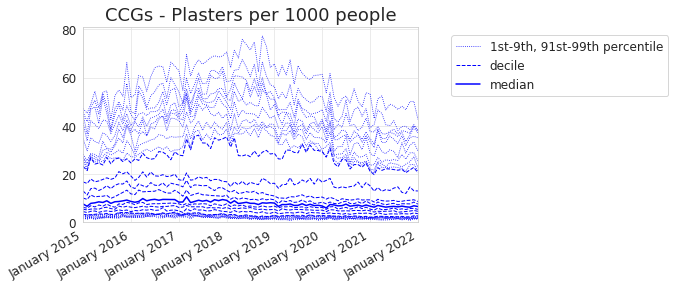

In [7]:
#plot deciles 
charts.deciles_chart(
        lidocaine_and_listsize,
        period_column='month',
        column= 'plasters_per_1000',
        title="CCGs - Plasters per 1000 people",
        show_outer_percentiles=True)
plt.show()

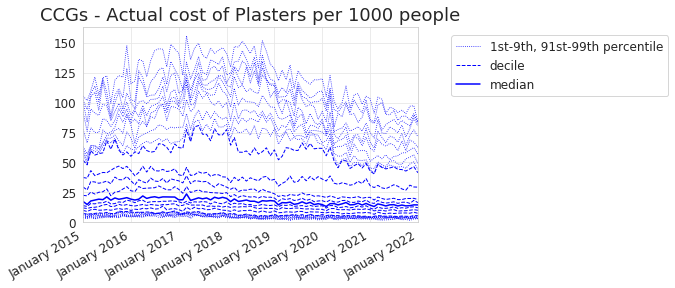

In [8]:
#plot deciles 
charts.deciles_chart(
        lidocaine_and_listsize,
        period_column='month',
        column= 'actual_cost_per_1000',
        title="CCGs - Actual cost of Plasters per 1000 people",
        show_outer_percentiles=True)

#add in example CCG (Newcastle Gateshead)
df_subject = lidocaine_and_listsize.loc[lidocaine_and_listsize['pct'] == '13T']
plt.plot(df_subject['month'], df_subject['items_per_1000'], 'r--')


plt.show()

## Charts
Here we will draw some charts to ilustrate national patterns

(0, 800000)

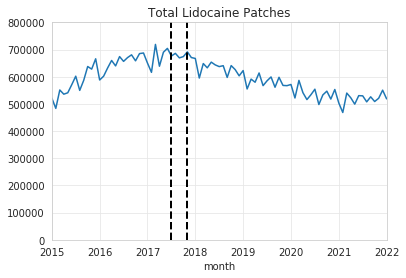

In [9]:
# total number of patches
ax = df_lidocaine.groupby(["month"])['quantity_of_plasters'].sum().plot(kind='line', title="Total Lidocaine Patches")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, 800000)

(0, 1637195.6856034999)

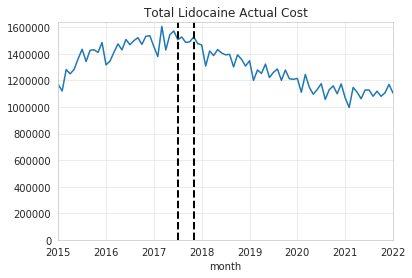

In [10]:
# total actual cost
ax = df_lidocaine.groupby(["month"])['actual_cost'].sum().plot(kind='line', title="Total Lidocaine Actual Cost")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, )

In [11]:
# total net cost

(0, 1768105.7745000003)

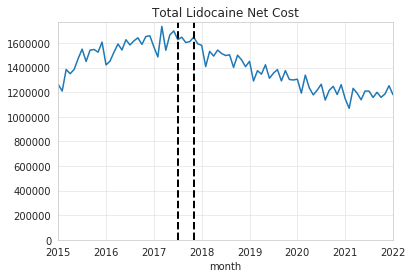

In [12]:
ax = df_lidocaine.groupby(["month"])['net_cost'].sum().plot(kind='line', title="Total Lidocaine Net Cost")
ax.axvline(pd.to_datetime('2017-07-01'), color='black', linestyle='--', lw=2) ##policy announced
ax.axvline(pd.to_datetime('2017-11-01'), color='black', linestyle='--', lw=2) ##consultation implemented
plt.ylim(0, )